In [1]:
import pandas as pd
import os
from visualization import *

In [2]:
dataset = "simulation3"
subset_col = "subset"
subset_value = 'B'
model = 'tree'
metric='rmse'

In [3]:
results_df = pd.read_csv(f"results/{dataset}/{subset_col}.csv")
subset_values = set(results_df[subset_col])

{'A': <Figure size 1600x500 with 12 Axes>,
 'B': <Figure size 1600x500 with 12 Axes>}

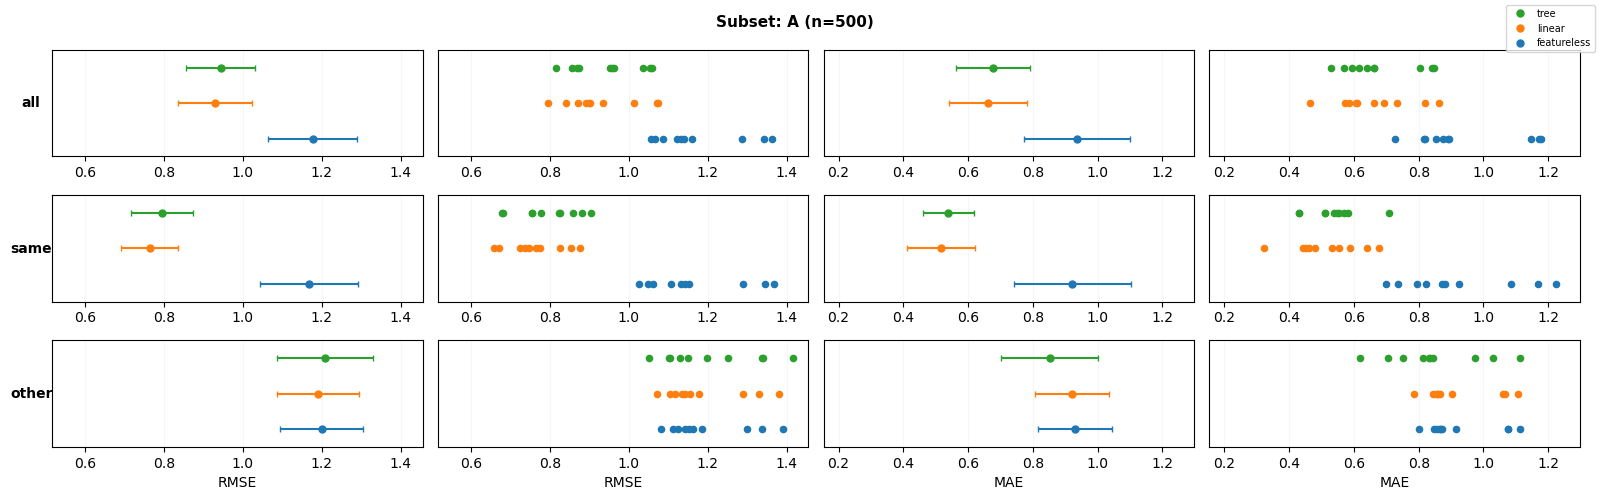

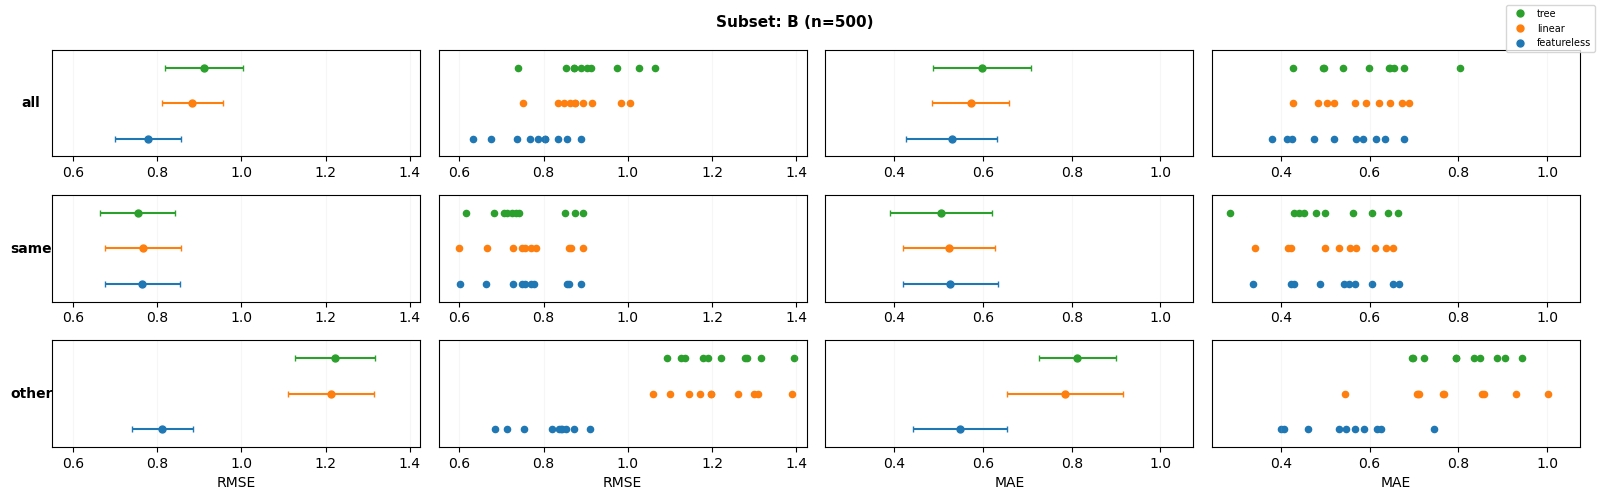

In [4]:
soak_plot_multiple_models(results_df)

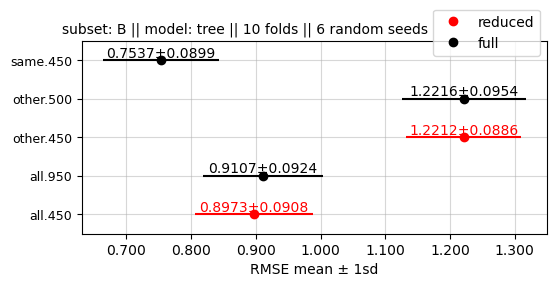

In [5]:
soak_plot_one_model(results_df, subset_value, model)

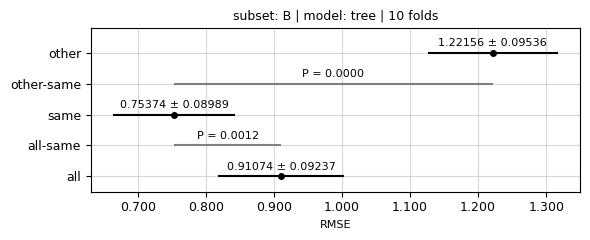

In [6]:
soak_plot_one_model_extend(results_df, subset_value, model)

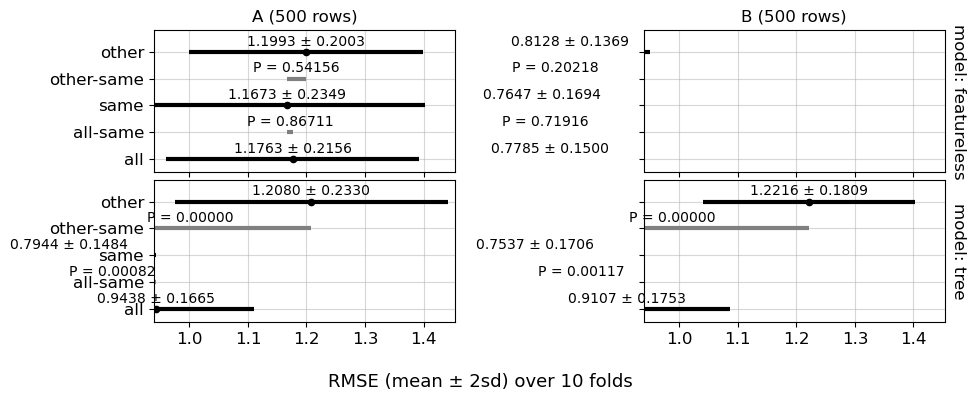

In [7]:
soak_plot_matrix(results_df, models=["featureless", "tree"], subset_values=subset_values, subplot_size=(5, 2), extend=(0.0, 0.002))

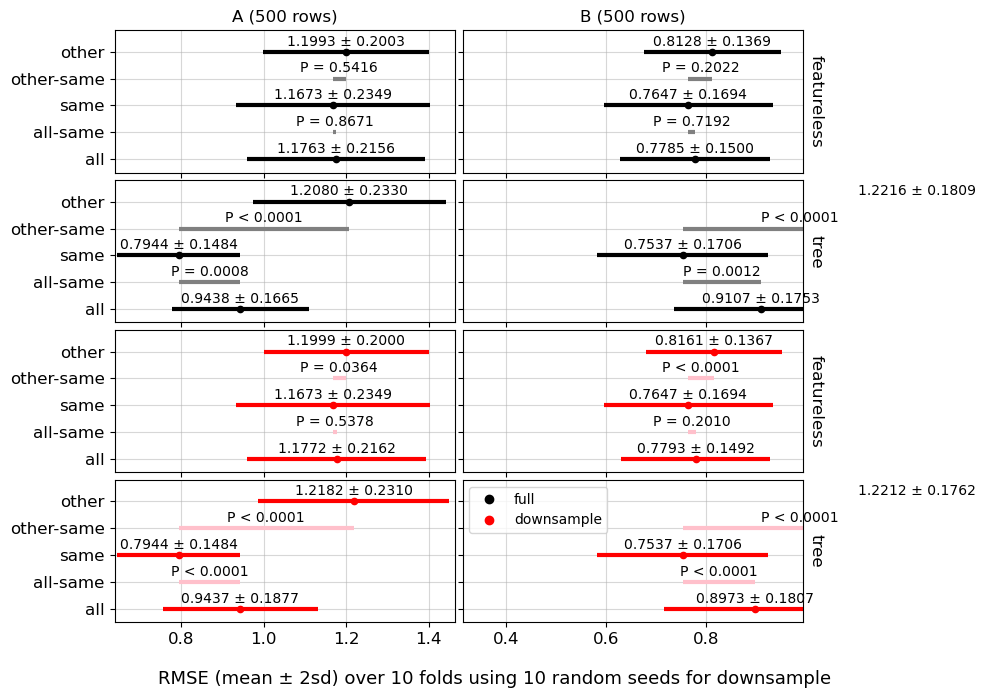

In [8]:
soak_plot_matrix_downsample(results_df, models=["featureless", "tree"], subset_values=subset_values, subplot_size=(5, 3.5), extend=(0.015, 0.0025))

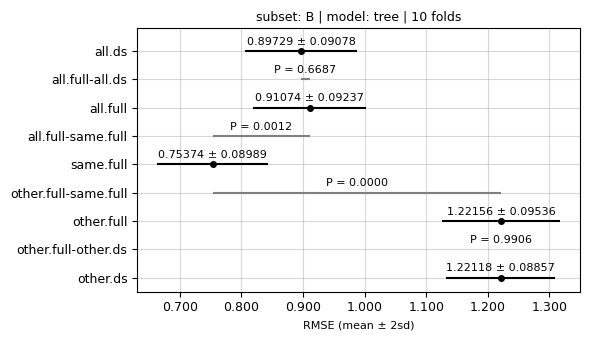

In [9]:
soak_plot_one_model_extend_downsample(results_df, subset_value, model, metric, figsize=(6, 3.5))

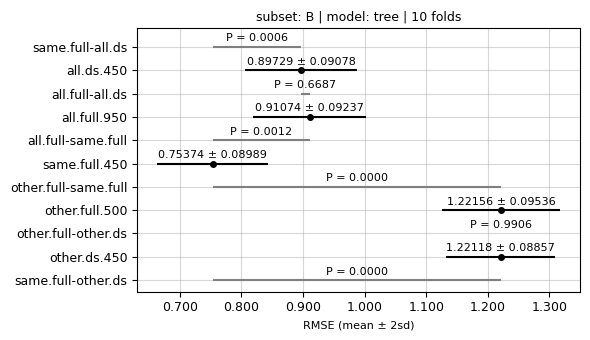

In [10]:
soak_plot_one_model_extend_downsample_2(results_df, subset_value, model, metric, figsize=(6, 3.5))

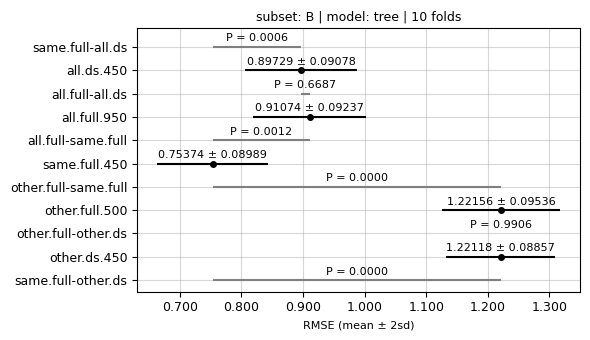

In [11]:
soak_plot_one_model_extend_downsample_3(results_df, subset_value, model, metric, figsize=(6, 3.5))

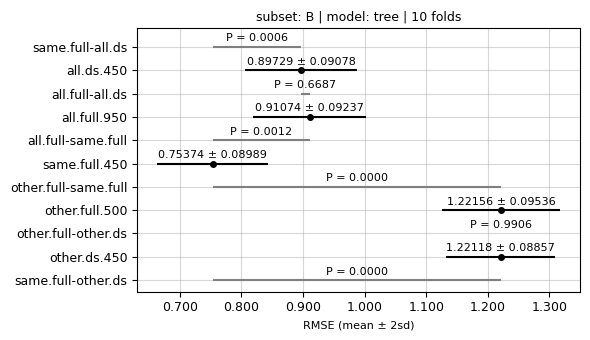

In [12]:
soak_plot_one_model_extend_downsample_4(results_df, subset_value, model, metric, figsize=(6, 3.5))

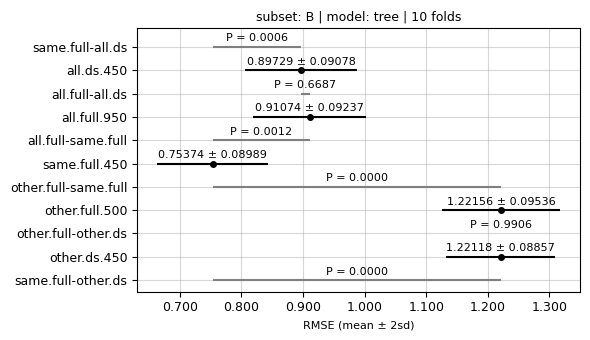

In [13]:
soak_plot_one_model_extend_downsample_4(results_df, subset_value, model, metric, figsize=(6, 3.5))

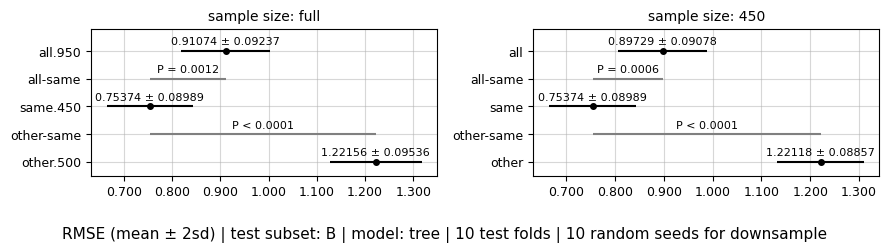

In [14]:
soak_plot_one_model_downsample_split(results_df, subset_value, model, metric, figsize=(9, 2.5))